In [1]:
to_train_ln = false
save_fig = true
push!(LOAD_PATH,"../src")
push!(LOAD_PATH,"../../src")
include("../example/test4_funnel/funnel_train.jl")
folder = "../example/test4_funnel/";

using ModDyn
using Printf
using ModUtil: repeat_experiment

include("plot_training.jl");

using StatsPlots, DataFrames

using Plots
using LaTeXStrings
using Plots.PlotMeasures

gr()

default(titlefont = (12), legendfontsize=8, 
    guidefont = (11), 
    fg_legend = :transparent)

figsize=(350,250);

# 0. Resrouces

In [2]:
Sys.cpu_info()[1].model, nprocs()

("Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz", 1)

# 1. Training results

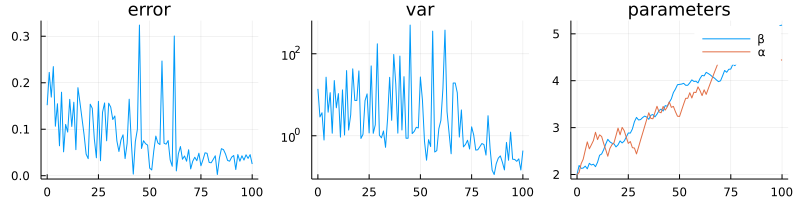

In [3]:
tmname = "sym"
if tmname == "sym"
    tm = -1/2
else
    tm = -0.0
end

model_num = 5
casename_ln = @sprintf("case_%d_model_%d_%d_%d_%d_%d_%d_%s_%s",
             testcasenum, model_num, σ₀^2,
             n, N, numsample_max, seed, train_method, tmname)
est_fst_m, est_sec_m, est_grad_norm, est_para, flow_ln, flow_ln_bef = load(folder*casename_ln*"_ln_data.jld2", 
    "est_fst_m", "est_sec_m", "est_grad_norm", "est_para", "flow_ln", "flow_ln_bef");


# Plot training result

fig1 = Plots.plot(0:1:train_step, abs.(est_fst_m/exact_mean.-1),
    label="", title="error")
fig2 = Plots.plot(0:1:train_step, (est_sec_m .- est_fst_m.^2)/exact_mean^2,
    label="", yscale=:log10, title="var")
fig3 = Plots.plot(0:1:train_step, [item[1][1] for item in est_para],
    label="β", title="parameters")
Plots.plot!(0:1:train_step, [item[1][2] for item in est_para],
    label="α")
fig = Plots.plot(fig1, fig2, fig3, size=(800,200), layout =@layout Plots.grid(1,3))

save_fig ? Plots.savefig(fig, "assets/test4_train_"*tmname*".pdf") : nothing

fig

# 2. Comparison under similar costs

In [4]:
U₀.sampler = (j)->σ₀*randn(n)

numrepeat = 10
numsample = 10^3

Random.seed!(seed)

s1 = 200
s2 = 20

K = 10
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1
fun_ais_10 = numsample->mean(map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample*s1)))
time_ais_10 = @elapsed data_ais_10_rep = repeat_experiment(fun_ais_10, numsample, numrepeat, gpts, gpts_sampler);

K = 100
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1
fun_ais_100 = numsample->mean(map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample*s2)))
time_ais_100 = @elapsed data_ais_100_rep = repeat_experiment(fun_ais_100, numsample, numrepeat, gpts, gpts_sampler);

flow_gd = generate_gradient_flow(UU₁, 2.0, Ωq);
fun_gd = numsample-> ModOptInt.get_data_err_var(n, U₀, U₁, flow_gd, N, tm, numsample, solver=solver)[2]
time_gd = @elapsed data_gd_rep = repeat_experiment(fun_gd, numsample, numrepeat, gpts, gpts_sampler);

fun_ln_bef = numsample->ModOptInt.get_data_err_var(n, U₀, U₁, flow_ln_bef, N, tm, numsample, solver=solver)[2]
time_ln_bef = @elapsed data_ln_bef_rep = repeat_experiment(fun_ln_bef, numsample, numrepeat, gpts, gpts_sampler);

fun_ln = numsample->ModOptInt.get_data_err_var(n, U₀, U₁, flow_ln, N, tm, numsample, solver=solver)[2]
time_ln = @elapsed data_ln_rep = repeat_experiment(fun_ln, numsample, numrepeat, gpts, gpts_sampler);

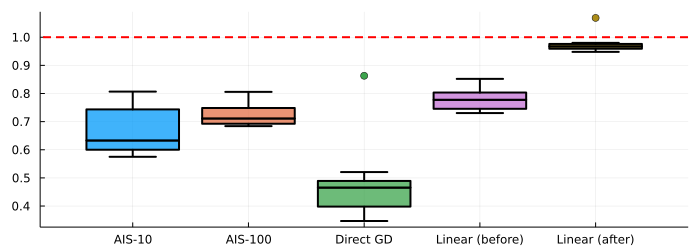

In [5]:
df = DataFrame(ais10=data_ais_10_rep/exact_mean, 
    ais100=data_ais_100_rep/exact_mean, 
    gd=data_gd_rep/exact_mean,
    lnbef=data_ln_bef_rep/exact_mean,
    ln=data_ln_rep/exact_mean)
fig = @df df StatsPlots.boxplot([:ais10, :ais100, :gd, :lnbef, :ln], 
    xticks = (1:1:5, ["AIS-10", "AIS-100", "Direct GD", "Linear (before)", "Linear (after)"]),
    fillalpha = 0.75, linewidth=2, label="", size=(700, 250), outliers=true)
plot!(0:1:6, ones(7), linewidth=2, label="", color=:red, linestyle=:dash)
plot!(xlim=(0.2, 5.8))

save_fig ? Plots.savefig(fig, "assets/test4_compare"*tmname*".pdf") : nothing

fig

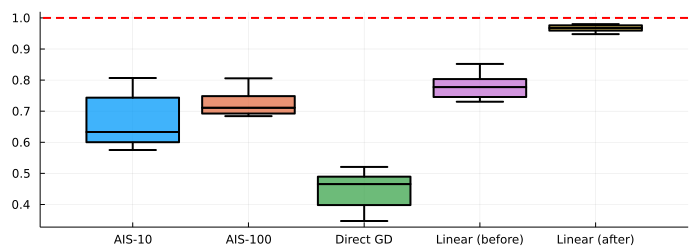

In [6]:
fig_no_outlier = @df df StatsPlots.boxplot([:ais10, :ais100, :gd, :lnbef, :ln], 
    xticks = (1:1:5, ["AIS-10", "AIS-100", "Direct GD", "Linear (before)", "Linear (after)"]),
    fillalpha = 0.75, linewidth=2, label="", size=(700, 250), outliers=false)
plot!(0:1:6, ones(7), linewidth=2, label="", color=:red, linestyle=:dash)
plot!(xlim=(0.2, 5.8))

save_fig ? Plots.savefig(fig_no_outlier, "assets/test4_compare"*tmname*"_no_outlier.pdf") : nothing

fig_no_outlier

## Time costs

In [7]:
println(time_ais_10)
println(time_ais_100)
println(time_gd)
println(time_ln_bef)
println(time_ln)

72.527848529
71.369784208
51.355968841
55.987005966
52.078224814


# 3. Flows

In [8]:
using ModTraj
using BasicInterpolators

T = 1.0
t_vec = Array(range(0,stop=1.0,length=Int64(ceil(T*50))+1))
unit_step = 5
num_particle = 100
traj_gpts = [σ₀*randn(n) for i = 1:num_particle]

flow = flow_ln

xmin = -10
xmax = 5
ymin = -3
ymax = 3

xc = range(xmin, stop=xmax, length=10^2)
yc = range(ymin, stop=ymax, length=10^2)

φ = x -> log10.(x)
Z₁  = sqrt(2*π)^n*σf*reduce_percent
ρ₁(x,y) = exp(-U₁.U(vcat([x,y],zeros(n-2))))/Z₁
;

## Flow lines for linear dynamics

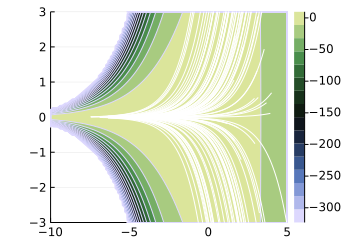

In [9]:
fig_ln_aft = Plots.contour(xc, yc, (x,y)-> φ(ρ₁(x,y)), fill=true, 
    color=:tofino, 
    size=figsize, xlim=(xmin,xmax),ylim=(ymin,ymax), left_margin=20px, right_margin=20px)
plot_traj(num_particle, traj_gpts, flow, t_vec, unit_step)

save_fig ? Plots.savefig(fig_ln_aft, @sprintf("assets/test4_ln_flow_%s.pdf", tmname)) : nothing

fig_ln_aft

## Flow lines for gradient dynamics

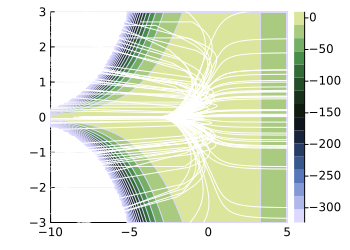

In [10]:
t_vec = Array(range(0,stop=1.0,length=Int64(ceil(T*50))+1))

# a very very small time step is needed
unit_step = 100

fig_gd = Plots.contour(xc, yc, (x,y)-> φ(ρ₁(x,y)), fill=true, 
    color=:tofino, 
    size=figsize, xlim=(xmin,xmax),ylim=(ymin,ymax), left_margin=20px, right_margin=20px)
plot_traj(num_particle, traj_gpts, flow_gd, t_vec, unit_step)

fig_gd

# 4. More testings

## 4.1 Estimate efficiency of NEIS

In [11]:
Random.seed!(1)
numsample_neis = 10^4

function estimate_neis_efficiency(; verbose=false)

    time_neis = @elapsed data, emp_m, emp_var = 
        ModOptInt.get_data_err_var(n, U₀, U₁, flow_ln, N, tm, numsample_neis, solver=solver);
    time_neis_per_sample = time_neis/length(data)
    var_neis = emp_var/exact_mean^2
    eff_neis = var_neis * time_neis_per_sample
    
    if verbose
        @printf("total time %.2f\n", time_neis)
        @printf("mean %.2E\n", mean(data)/exact_mean)
        @printf("efficiency %.2E\n", eff_neis)
        println()
    end
    
    return time_neis, time_neis_per_sample, var_neis, eff_neis
    
end
;

In [12]:
stat_neis_vec = map(j->estimate_neis_efficiency(verbose=true), 1:5)
eff_neis_vec = [item[4] for item in stat_neis_vec]
print(eff_neis_vec)

total time 55.40
mean 9.82E-01
efficiency 1.49E-02

total time 55.06
mean 9.75E-01
efficiency 1.02E-02

total time 55.19
mean 9.69E-01
efficiency 6.97E-03

total time 55.13
mean 9.80E-01
efficiency 2.21E-02

total time 55.16
mean 1.00E+00
efficiency 8.95E-02

[0.014897048845221417, 0.010208592779622709, 0.006968329891681831, 0.02205494020794264, 0.08945016524973057]

## 4.2 Efficiency for AIS

In [13]:
import Statistics: std, mean

K = 100
βlist = Array(range(0, stop=1.0, length=K+1))
τ = 0.1

numsample_ais = 10^6

function estimate_ais_efficiency(; verbose=true)
    time_ais = @elapsed estimate = map(j->ais_neal(U₀.sampler(j), n, U₀, U₁, K, βlist, τ)[1], 1:(numsample_ais))
    time_per_sample = time_ais/numsample_ais
    var_ais = std(estimate, corrected=false).^2/exact_mean^2
    eff_ais_100 = time_per_sample * var_ais
    
    if verbose
        @printf("Total time %.2f\n", time_ais)
        @printf("Mean is %.3f variance %.2E\n", mean(estimate)/exact_mean, var_ais) 
        println(eff_ais_100)
        println()
    end
    
    return time_ais, time_per_sample, var_ais, eff_ais_100
end
;

In [14]:
stat_ais_100 = map(j->estimate_ais_efficiency(verbose=true), 1:5)
eff_ais_100 = [item[4] for item in stat_ais_100]

Total time 362.41
Mean is 0.815 variance 5.23E+03
1.8970488283750602

Total time 362.32
Mean is 0.726 variance 3.64E+02
0.13183840897981108

Total time 363.61
Mean is 0.742 variance 2.46E+02
0.08934763982862141

Total time 365.14
Mean is 0.743 variance 2.64E+02
0.09627970065031113

Total time 365.69
Mean is 0.774 variance 4.67E+02
0.17090652268391157



5-element Vector{Float64}:
 1.8970488283750602
 0.13183840897981108
 0.08934763982862141
 0.09627970065031113
 0.17090652268391157

In [15]:
err_std = 0.01
@printf("AIS takes around %.2f hours to achieve %.2E std error\n", 
    median(eff_ais_100)/err_std^2/(3600), err_std)

AIS takes around 0.37 hours to achieve 1.00E-02 std error


## 4.3 Cost ratio

In [16]:
minimum(eff_neis_vec)/maximum(eff_ais_100), maximum(eff_neis_vec)/minimum(eff_ais_100)

(0.003673247513428865, 1.0011474888570735)

In [17]:
std(eff_ais_100)/mean(eff_ais_100), std(eff_neis_vec)/mean(eff_neis_vec)

(1.6652154795050116, 1.1987073162292932)

In [18]:
median(eff_neis_vec)/median(eff_ais_100)

0.11299475593264068